In [1]:




from imutils import paths
import tensorflow as tf
# from tf.data import AUTOTUNE
# tf.data.experimental.AUTOTUNE




from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import models, regularizers, layers, optimizers, losses, metrics

from tensorflow.keras.models import *
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow.keras.applications.resnet_v2 import ResNet50V2
import random

from wandb.keras import WandbCallback
%autosave 1

2023-04-02 01:02:44.303477: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 01:02:44.854466: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Autosaving every 1 seconds


In [3]:
notebook_name = None

%%javascript
IPython.notebook.kernel.execute('notebook_name = "' + IPython.notebook.notebook_name + '"')

if notebook_name is None:
    notebook_name = 'component_classification.ipynb'
print(notebook_name)

<IPython.core.display.Javascript object>

In [6]:
from tensorflow.python.keras import backend as K
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
K.set_session(sess)


2023-04-02 01:02:46.154039: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-02 01:02:46.188428: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-02 01:02:46.188698: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [7]:
from time import gmtime, strftime
session_key = strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(session_key)

2023-04-01-19-32-46


In [9]:
import wandb

os.environ['WANDB_NOTEBOOK_NAME'] = notebook_name

wandb.init(project="component-classification",
        config={
            "learning_rate": None,
            "epochs":  None,
            "batch_size":  None,
            "val_split":  None,
            "dropout":  None,
            "image_width":  None,
            "image_height":  None,
            "random_seed":  None,
            "session_key":  None,
            "model_name": "ResNet50V2",
            "train_accuracy": None,
            "val_accuracy": None,
            "test_accuracy": None,
            "class_weight_strategy": None,
            "fine_tuning": None,
            "pad_input": None,
            "pad_strategy":None
        })

w_config = wandb.config



wandb: Currently logged in as: vamsidhar_muthireddy. Use `wandb login --relogin` to force relogin


<pre>
w_config.learning_rate = #Learning rate <br/>
w_config.epochs = Number of Epochs <br/>
w_config.batch_size = Batch size <br/>
w_config.val_split = Validation split <br/>
w_config.dropout = Fropout in FC layers <br/>
w_config.image_width = Image width for CNN <br/>
w_config.image_height = Image height for CNN <br/>
w_config.random_seed = Random seed <br/>
w_config.session_key = Session key to save results(test folder name) <br/>
w_config.model_name = Model Name <br/>

w_config.train_accuracy = training set accuracy (Will be polulated after model training) <br/>
w_config.val_accuracy = validation set accuracy (Will be polulated after model training) <br/>
w_config.test_accuracy = test set accuracy (Will be polulated after model training) <br/>

w_config.class_weight_strategy = #keys: None : No class weigts <br/>
                                        "Original": Class weights are set according to original dataset <br/>
                                
w_config.fine_tuning = #keys: True: Fine-tunes the model by freezing ResNet head <br/>
                              False: Model is trained in usual way <br/>
                              
w_config.pad_input = #keys: True : Resize the input by padding to target shape <br/>
                          : False : Resize the input to target shape <br/>

w_config.pad_strategy = #keys: 'pad_only' : if larger dimension < target shape: Pad the shorter and larger dimension to the target shape <br/>
                                           :if larger dimension > target shape: resize by scale_and_pad strategy <br/>
                             : 'scale_and_pad' : Pad the shorter dimension to match the larger dimenion before scaling to the target shape <br/>
                             
</pre>

In [10]:
w_config.learning_rate = 0.001
w_config.epochs = 30
w_config.batch_size = 128
w_config.val_split = 0.2
w_config.dropout = 0.1
w_config.image_width = 128
w_config.image_height = 128
w_config.random_seed = 42
w_config.session_key = session_key
w_config.model_name = "ResNet50V2"
w_config.train_accuracy = 0
w_config.val_accuracy = 0
w_config.test_accuracy = 0
w_config.class_weight_strategy = "Augmented"    #keys: None, "Original", "Augmented"
w_config.fine_tuning = False                     #Fine-tunes the model if True
w_config.pad_input = True
w_config.pad_strategy = 'pad_only'      #keys: 'pad_only', 'scale_and_pad'

Organizing data for model training and inferencing



Model training will happen on images from train_folder <br>
train_folder = Training set (Will be split into train and validation to be used for model training)

Model inferencing will happen on images from test_folder <br>
test_folder = Test set (Will be used to evaluate the trained model for <b>inference</b>)



In [11]:

shuffle_dataset = True



save_folder = '/home/vamsidhar/Documents/purecode/solution_1/test_' + str(w_config.session_key)
print(save_folder)
os.makedirs(save_folder, exist_ok=True)

model_save_path = os.path.join(save_folder, "model_weights.h5")
architecture_save_path = os.path.join(save_folder, "model_architecture.txt")


np.random.seed(w_config.random_seed)
tf.random.set_seed(w_config.random_seed)
random.seed(w_config.random_seed)


train_folder = '/home/vamsidhar/Documents/purecode/data_3/train/images'
test_folder = '/home/vamsidhar/Documents/purecode/data_3/test/images'




/home/vamsidhar/Documents/purecode/solution_1/test_2023-04-01-19-32-46


In [14]:


def get_weights(classes , folder):
    each_class_samples = []
    for i in classes : 
        each_class_samples.append(len(os.listdir(os.path.join(folder,i))))
    maximum = max(each_class_samples)
    weight_list = []
    for i in each_class_samples:
        weight_list.append(maximum/i)
    weights = {}
    for i in range(len(weight_list)) :
        weights[i] =  weight_list[i]  
    return weights



In [15]:
classes_train = os.listdir(train_folder)
classes_test   = os.listdir(test_folder)

print(classes_train)
num_classes = len(classes_train)

class_weights = get_weights(classes_train , train_folder)
    
print(class_weights)



['Switch', 'Checkbox', 'Card', 'Icon', 'Button']
{0: 14.143730886850152, 1: 3.630298273155416, 2: 2.132319041032734, 3: 1.0, 4: 1.7439668174962293}


In [16]:
def label_encoding (label , path):
    C = tf.constant(len(os.listdir(path)), name = "C")

    one_hot_matrix = tf.one_hot(label, C, on_value = 1.0, off_value = 0.0, axis =-1)
    one_hot = tf.cast(one_hot_matrix, dtype=tf.int64)
    
    return one_hot

In [17]:
def iterator(path ):
    label = []
    file_name = []
    folder_lis = os.listdir(path)
    for i in range(len(folder_lis)) :
        img_lis = os.listdir(os.path.join(path,folder_lis[i]))
        for j in img_lis :
            label.append(i)
            file_name.append(os.path.join(path,folder_lis[i],j))  
    label_1 = label_encoding (label , path)
    
    return label_1, file_name 

In [18]:
def run_time_augmentation(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    image = tf.image.random_brightness(image, max_delta=12.0 / 255.0)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image

In [19]:
def parse_function(filename, label, aug, input_dim = [w_config.image_height, w_config.image_width] ):
    image_string = tf.io.read_file(filename)
    img = tf.image.decode_png(image_string, channels=3)
    img = tf.cast(img , tf.float32)
    if w_config.pad_input:
        if w_config.pad_strategy == 'pad_only':
            x_offset = int((input_dim[1] - tf.shape(img)[1])/2)
            y_offset = int((input_dim[0] - tf.shape(img)[0])/2)

            offset_positive = tf.greater(x_offset, 0) and tf.greater(y_offset, 0)

            # print(input_dim[1], tf.shape(img), offset_positive, x_offset, y_offset)
            img = tf.cond(
                    offset_positive,
                    false_fn = lambda:tf.image.resize_with_pad(img, input_dim[0], input_dim[1]),  
                    true_fn = lambda:tf.image.pad_to_bounding_box( img, offset_height=y_offset,
                                                                    offset_width=x_offset,
                                                                    target_height=input_dim[0],
                                                                    target_width=input_dim[1] ),                                
                    name = None
                    )
            
        else:
            img =  tf.image.resize_with_pad(img, input_dim[0], input_dim[1])
            
    else:
        img  = tf.image.resize(img, input_dim)
        
    image_raw = tf.cast(img , tf.float32) * (1. / 255)

    if aug:
        image_raw = run_time_augmentation(image_raw)
    return image_raw, label



In [20]:
def give_generator_v2(file_names, labels, shuffle=True, batch_size=256, repeat=True,buffer_size=512,
                       prefetch=True, autotune=False, parallel_calls=2*os.cpu_count()-2, aug=False):
    
    aug_list = [aug]*len(labels)
    dataset = tf.data.Dataset.from_tensor_slices((file_names, labels, aug_list))
    
    
    if repeat:
        dataset = dataset.repeat()
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(file_names))
    
    if autotune:
        dataset = dataset.map(parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    else:
        dataset = dataset.map(parse_function, num_parallel_calls=parallel_calls)

        
    dataset = dataset.batch(batch_size)
    
    if prefetch:
        if autotune:
            dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
        else:
            dataset = dataset.prefetch(parallel_calls)
            

    data_gen = iter(dataset)
    
    return data_gen, dataset

In [21]:
def generate_filenames_label(path, shuffle=True, split=False, split_ratio=w_config.val_split):
    label, file_name  = iterator(path)
    
    if split:

        dataset_size = len(file_name)
        indices = list(range(dataset_size))
        total_split = int(np.floor((split_ratio) * dataset_size))
        if shuffle :
            np.random.shuffle(indices)
        train_indices, val_indices = indices[total_split:], indices[:total_split]
        
        train_label = np.take(label, train_indices, axis=0)
        train_file_name = np.take(file_name, train_indices, axis=0)
        
        val_label = np.take(label, val_indices, axis=0)
        val_file_name = np.take(file_name, val_indices, axis=0)
        
        
        return train_label, train_file_name, val_label, val_file_name
    
    return label, file_name


    
    

In [22]:
train_label, train_file_name, val_label, val_file_name = generate_filenames_label(train_folder,
                                                                                  shuffle=True,
                                                                                  split=True,
                                                                                  split_ratio=w_config.val_split)



2023-04-02 01:02:52.854594: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-02 01:02:52.854821: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-02 01:02:52.854979: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [23]:
test_label, test_file_name  = generate_filenames_label(test_folder, shuffle=False, split=False)



Defining train, validation, and test generators.

Flags:

shuffle: True by default.
Train and validation data will be shuffled during each epoch. Test data will be fed with no shuffling


aug: False by default.
Run time augmenations will be performed only on Training part of the data. Validation and Test sets will have no run time augmentations. We preprocess the images by resizing and normalization


In [24]:
train_data_gen, train_dataset_tf = give_generator_v2(file_names=train_file_name, labels=train_label, shuffle=True, 
                                   batch_size=w_config.batch_size, repeat=True, buffer_size=512, prefetch=True, aug=True)

val_data_gen, val_dataset_tf = give_generator_v2(file_names=val_file_name, labels=val_label, shuffle=True, 
                                 batch_size=w_config.batch_size, repeat=True, buffer_size=512, prefetch=True)

test_data_gen, test_dataset_tf = give_generator_v2(file_names=test_file_name, labels=test_label, shuffle=False,
                                  batch_size=w_config.batch_size, repeat=True, buffer_size=512, prefetch=True)

2023-04-02 01:02:53.375170: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [8838]
	 [[{{node Placeholder/_0}}]]
2023-04-02 01:02:53.375573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [8838,5]
	 [[{{node Placeholder/_1}}]]
2023-04-02 01:02:53.612529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype bool and shape [2209]

In [25]:


def model_resnet50(classes = num_classes, fine_tuning=False, fine_tuning_layer=None, fine_tuning_model=None):

    if fine_tuning is True and fine_tuning_layer is not None and fine_tuning_model is not None:
        input1 = fine_tuning_model.input
        base_model = Model(input1,
                           fine_tuning_model.layers[fine_tuning_layer - len(fine_tuning_model.layers)].output)
        for i in range(len(base_model.layers)):
            base_model.layers[i].trainable = False
    else:
        input1 = Input(shape=(w_config.image_width, w_config.image_height,3))
        base_model = ResNet50V2(include_top=False, weights='imagenet', input_tensor=input1,
                                input_shape=(w_config.image_width, w_config.image_height,3),
                                    pooling='max')
    x = base_model.output
    x = Dense(classes, activation='softmax')(x)
    model = Model(inputs=input1, outputs=x)
#     model.name = 'resnet50v2'
    return model

Defining the model

In [26]:


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=15, verbose =2 )


checkpoint = ModelCheckpoint(model_save_path, save_weights_only= True, monitor='val_loss', verbose=2,
                            save_best_only=True, mode='auto', save_freq='epoch')


Intiliazing the model. 

If  `w_config.fine_tuning` is set as `True`, fine-tuning is selected, 
1. Model weight are initialized from weight file at `base_model_path`
2. Layers of Resnet are set as non-trainable.
3. Only FC layers added are trainable

In [27]:




model = model_resnet50(classes=num_classes)

# model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=w_config.learning_rate), metrics=['accuracy'])

if w_config.fine_tuning:
    if os.path.isfile(base_model_path):
        cnn_arch_str = open(base_model_architecture_path, 'r+')
        model = model_from_json((cnn_arch_str.read()))
        model.load_weights(base_model_path)
        pooling_layer_index = 0
        for i in range(len(model.layers)):
            if model.layers[i].name == 'max_pool':
                pooling_layer_index = i
        
        model = model_resnet50(classes=num_classes, fine_tuning=True, fine_tuning_layer=pooling_layer_index, fine_tuning_model=model)

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=w_config.learning_rate), metrics=['accuracy'])



Model training

In [28]:

history = model.fit(
                train_dataset_tf,
                steps_per_epoch= len(train_file_name)// w_config.batch_size,
                epochs=w_config.epochs,
                validation_data=val_dataset_tf,
                validation_steps= len(val_file_name)// w_config.batch_size,
                callbacks = [checkpoint, reduce_lr, WandbCallback()], 
                class_weight = class_weights,
                verbose=1
                )


# history = model.fit_generator(
#                 train_data_gen,
#                 steps_per_epoch= len(train_file_name)// w_config.batch_size,
#                 epochs=w_config.epochs,
#                 validation_data=val_data_gen,
#                 validation_steps= len(val_file_name)// w_config.batch_size,
#                 callbacks = [checkpoint, reduce_lr, WandbCallback()], 
#                 class_weight = class_weights,
#                 verbose=1
#                 )

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/30


2023-04-02 01:02:55.539567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype bool and shape [8838]
	 [[{{node Placeholder/_2}}]]
2023-04-02 01:02:55.539860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [8838,5]
	 [[{{node Placeholder/_1}}]]
2023-04-02 01:03:05.010917: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-04-02 01:03:06.195512: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-02 01:03:07.784993: W tensorflow/tsl/framework

 6/69 [=>............................] - ETA: 21s - loss: 7.5869 - accuracy: 0.6094WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1571s vs `on_train_batch_end` time: 0.1607s). Check your callbacks.


69/69 [==============================] - ETA: 0s - loss: 1.1052 - accuracy: 0.8998
Epoch 1: val_loss improved from inf to 362.64294, saving model to /home/vamsidhar/Documents/purecode/solution_1/test_2023-04-01-19-32-46/model_weights.h5


INFO:tensorflow:Assets written to: /home/vamsidhar/Documents/purecode/solution_1/wandb/run-20230402_010248-rn5x7grd/files/model-best/assets


INFO:tensorflow:Assets written to: /home/vamsidhar/Documents/purecode/solution_1/wandb/run-20230402_010248-rn5x7grd/files/model-best/assets
wandb: Adding directory to artifact (/home/vamsidhar/Documents/purecode/solution_1/wandb/run-20230402_010248-rn5x7grd/files/model-best)... Done. 0.7s


69/69 [==============================] - 76s 685ms/step - loss: 1.1052 - accuracy: 0.8998 - val_loss: 362.6429 - val_accuracy: 0.3263 - lr: 0.0010
Epoch 2/30
69/69 [==============================] - ETA: 0s - loss: 0.1731 - accuracy: 0.9690
Epoch 2: val_loss improved from 362.64294 to 0.62219, saving model to /home/vamsidhar/Documents/purecode/solution_1/test_2023-04-01-19-32-46/model_weights.h5


INFO:tensorflow:Assets written to: /home/vamsidhar/Documents/purecode/solution_1/wandb/run-20230402_010248-rn5x7grd/files/model-best/assets


INFO:tensorflow:Assets written to: /home/vamsidhar/Documents/purecode/solution_1/wandb/run-20230402_010248-rn5x7grd/files/model-best/assets
wandb: Adding directory to artifact (/home/vamsidhar/Documents/purecode/solution_1/wandb/run-20230402_010248-rn5x7grd/files/model-best)... Done. 0.7s


69/69 [==============================] - 45s 650ms/step - loss: 0.1731 - accuracy: 0.9690 - val_loss: 0.6222 - val_accuracy: 0.9605 - lr: 0.0010
Epoch 3/30
69/69 [==============================] - ETA: 0s - loss: 0.1141 - accuracy: 0.9800
Epoch 3: val_loss improved from 0.62219 to 0.05454, saving model to /home/vamsidhar/Documents/purecode/solution_1/test_2023-04-01-19-32-46/model_weights.h5


INFO:tensorflow:Assets written to: /home/vamsidhar/Documents/purecode/solution_1/wandb/run-20230402_010248-rn5x7grd/files/model-best/assets


INFO:tensorflow:Assets written to: /home/vamsidhar/Documents/purecode/solution_1/wandb/run-20230402_010248-rn5x7grd/files/model-best/assets
wandb: Adding directory to artifact (/home/vamsidhar/Documents/purecode/solution_1/wandb/run-20230402_010248-rn5x7grd/files/model-best)... Done. 0.8s


69/69 [==============================] - 49s 714ms/step - loss: 0.1141 - accuracy: 0.9800 - val_loss: 0.0545 - val_accuracy: 0.9816 - lr: 0.0010
Epoch 4/30
69/69 [==============================] - ETA: 0s - loss: 0.0829 - accuracy: 0.9852
Epoch 4: val_loss improved from 0.05454 to 0.04019, saving model to /home/vamsidhar/Documents/purecode/solution_1/test_2023-04-01-19-32-46/model_weights.h5


INFO:tensorflow:Assets written to: /home/vamsidhar/Documents/purecode/solution_1/wandb/run-20230402_010248-rn5x7grd/files/model-best/assets


INFO:tensorflow:Assets written to: /home/vamsidhar/Documents/purecode/solution_1/wandb/run-20230402_010248-rn5x7grd/files/model-best/assets
wandb: Adding directory to artifact (/home/vamsidhar/Documents/purecode/solution_1/wandb/run-20230402_010248-rn5x7grd/files/model-best)... Done. 0.8s


69/69 [==============================] - 50s 724ms/step - loss: 0.0829 - accuracy: 0.9852 - val_loss: 0.0402 - val_accuracy: 0.9867 - lr: 0.0010
Epoch 5/30
69/69 [==============================] - ETA: 0s - loss: 0.0684 - accuracy: 0.9877
Epoch 5: val_loss did not improve from 0.04019
69/69 [==============================] - 29s 416ms/step - loss: 0.0684 - accuracy: 0.9877 - val_loss: 0.0501 - val_accuracy: 0.9858 - lr: 0.0010
Epoch 6/30
69/69 [==============================] - ETA: 0s - loss: 0.0696 - accuracy: 0.9894
Epoch 6: val_loss did not improve from 0.04019
69/69 [==============================] - 31s 455ms/step - loss: 0.0696 - accuracy: 0.9894 - val_loss: 0.0576 - val_accuracy: 0.9858 - lr: 0.0010
Epoch 7/30
69/69 [==============================] - ETA: 0s - loss: 0.1049 - accuracy: 0.9813
Epoch 7: val_loss did not improve from 0.04019
69/69 [==============================] - 33s 475ms/step - loss: 0.1049 - accuracy: 0.9813 - val_loss: 0.2310 - val_accuracy: 0.9334 - lr: 0.00

INFO:tensorflow:Assets written to: /home/vamsidhar/Documents/purecode/solution_1/wandb/run-20230402_010248-rn5x7grd/files/model-best/assets


INFO:tensorflow:Assets written to: /home/vamsidhar/Documents/purecode/solution_1/wandb/run-20230402_010248-rn5x7grd/files/model-best/assets
wandb: Adding directory to artifact (/home/vamsidhar/Documents/purecode/solution_1/wandb/run-20230402_010248-rn5x7grd/files/model-best)... Done. 1.4s


69/69 [==============================] - 69s 1s/step - loss: 0.0575 - accuracy: 0.9903 - val_loss: 0.0236 - val_accuracy: 0.9936 - lr: 0.0010
Epoch 11/30
69/69 [==============================] - ETA: 0s - loss: 0.0488 - accuracy: 0.9924
Epoch 11: val_loss did not improve from 0.02360
69/69 [==============================] - 32s 465ms/step - loss: 0.0488 - accuracy: 0.9924 - val_loss: 0.5459 - val_accuracy: 0.8686 - lr: 0.0010
Epoch 12/30
69/69 [==============================] - ETA: 0s - loss: 0.0506 - accuracy: 0.9916
Epoch 12: val_loss did not improve from 0.02360
69/69 [==============================] - 35s 505ms/step - loss: 0.0506 - accuracy: 0.9916 - val_loss: 0.0540 - val_accuracy: 0.9784 - lr: 0.0010
Epoch 13/30
69/69 [==============================] - ETA: 0s - loss: 0.0527 - accuracy: 0.9916
Epoch 13: val_loss did not improve from 0.02360
69/69 [==============================] - 39s 567ms/step - loss: 0.0527 - accuracy: 0.9916 - val_loss: 0.3152 - val_accuracy: 0.9324 - lr: 0

INFO:tensorflow:Assets written to: /home/vamsidhar/Documents/purecode/solution_1/wandb/run-20230402_010248-rn5x7grd/files/model-best/assets


INFO:tensorflow:Assets written to: /home/vamsidhar/Documents/purecode/solution_1/wandb/run-20230402_010248-rn5x7grd/files/model-best/assets
wandb: Adding directory to artifact (/home/vamsidhar/Documents/purecode/solution_1/wandb/run-20230402_010248-rn5x7grd/files/model-best)... Done. 1.6s


69/69 [==============================] - 107s 2s/step - loss: 0.0258 - accuracy: 0.9954 - val_loss: 0.0177 - val_accuracy: 0.9949 - lr: 5.0000e-04
Epoch 27/30
69/69 [==============================] - ETA: 0s - loss: 0.0402 - accuracy: 0.9922
Epoch 27: val_loss did not improve from 0.01772
69/69 [==============================] - 32s 471ms/step - loss: 0.0402 - accuracy: 0.9922 - val_loss: 0.0579 - val_accuracy: 0.9821 - lr: 5.0000e-04
Epoch 28/30
69/69 [==============================] - ETA: 0s - loss: 0.0250 - accuracy: 0.9960
Epoch 28: val_loss did not improve from 0.01772
69/69 [==============================] - 40s 578ms/step - loss: 0.0250 - accuracy: 0.9960 - val_loss: 0.0495 - val_accuracy: 0.9890 - lr: 5.0000e-04
Epoch 29/30
69/69 [==============================] - ETA: 0s - loss: 0.0207 - accuracy: 0.9969
Epoch 29: val_loss did not improve from 0.01772
69/69 [==============================] - 46s 669ms/step - loss: 0.0207 - accuracy: 0.9969 - val_loss: 0.0463 - val_accuracy: 0

In [29]:
%%javascript
$("#save-notbook button").trigger('click');

<IPython.core.display.Javascript object>

Plotting accuracy and loss curves obtained on training and validation dataset during model training phase

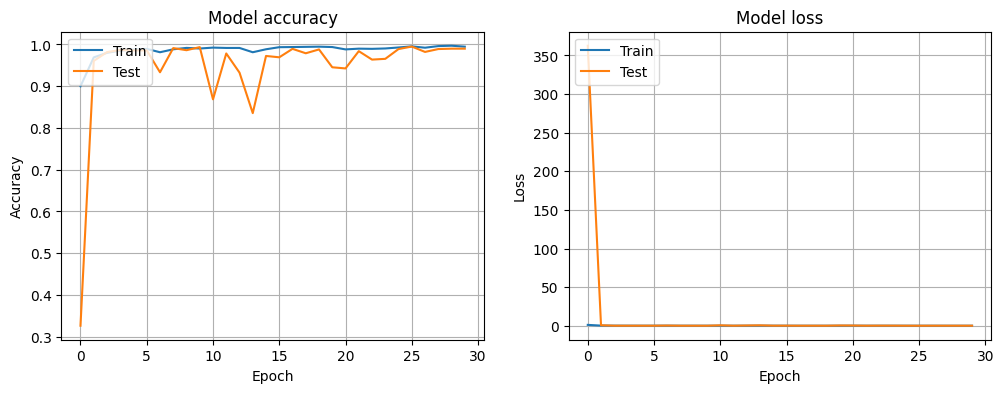

In [30]:

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid(True)

#plt.show()
# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid(True)
plt.savefig(os.path.join(save_folder, 'Acc_loss.png'))
plt.show() 

saving model architecture


In [31]:
json_string = model.to_json()
with open(architecture_save_path, 'w') as outfile:
    outfile.write(json_string)
    
cnn_arch_str = open(architecture_save_path, 'r+')
cnn_model = model_from_json((cnn_arch_str.read()))
# cnn_model.load_weights(weight_path)
cnn_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 66, 66, 64)   0           ['conv1_conv[0][0]']         

 vation)                                                                                          
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 32, 32, 64)   16384       ['conv2_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 32, 32, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 32, 32, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
          

 conv3_block2_2_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 16, 16, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 16, 16, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_block2_out (Add)         (None, 16, 16, 512)  0           ['conv3_block1_out[0][0]',       
                                                                  'conv3_block2_3_conv[0][0]']    
          

                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 8, 8, 256)   1024        ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_2_pad (ZeroPaddin  (None, 10, 10, 256)  0          ['conv4_block1_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv4_blo

 conv4_block3_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block3_2_relu[0][0]']    
                                                                                                  
 conv4_block3_out (Add)         (None, 8, 8, 1024)   0           ['conv4_block2_out[0][0]',       
                                                                  'conv4_block3_3_conv[0][0]']    
                                                                                                  
 conv4_block4_preact_bn (BatchN  (None, 8, 8, 1024)  4096        ['conv4_block3_out[0][0]']       
 ormalization)                                                                                    
                                                                                                  
 conv4_block4_preact_relu (Acti  (None, 8, 8, 1024)  0           ['conv4_block4_preact_bn[0][0]'] 
 vation)                                                                                          
          

 g2D)                                                                                             
                                                                                                  
 conv4_block6_2_conv (Conv2D)   (None, 4, 4, 256)    589824      ['conv4_block6_2_pad[0][0]']     
                                                                                                  
 conv4_block6_2_bn (BatchNormal  (None, 4, 4, 256)   1024        ['conv4_block6_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block6_2_relu (Activatio  (None, 4, 4, 256)   0           ['conv4_block6_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 max_pooli

 ormalization)                                                                                    
                                                                                                  
 conv5_block3_preact_relu (Acti  (None, 4, 4, 2048)  0           ['conv5_block3_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv5_block3_1_conv (Conv2D)   (None, 4, 4, 512)    1048576     ['conv5_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, 4, 4, 512)   2048        ['conv5_block3_1_conv[0][0]']    
 ization)                                                                                         
          

Loading the best model weights

In [32]:

# model = model_resnet50(classes=num_classes)
# model_name = 'ResNet50V2'
# model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
model.load_weights(model_save_path)

Test accuracy reported on test dataset. It should match the accuracy on validation dataset to evaluate the training process

In [33]:
test_loss, test_acc = model.evaluate(test_dataset_tf, steps=len(test_file_name)//w_config.batch_size)
print("\nThe test accuracy for " + w_config.model_name + " is ", test_acc, "\n")



21/21 [==============================] - 4s 189ms/step - loss: 0.0405 - accuracy: 0.9911

The test accuracy for ResNet50V2 is  0.9910714030265808 



In [34]:
%%javascript
$("#save-notbook button").trigger('click');

<IPython.core.display.Javascript object>

In [35]:
import pathlib

In [36]:
# 

In [37]:
%%javascript
$("#save-notbook button").trigger('click');

<IPython.core.display.Javascript object>

In [38]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                         save_name='conf_mat.png'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print(" ")

#     print(cm)
    plt.figure(figsize=(12,12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlim(-0.5, len(np.unique(classes))-0.5)
    plt.ylim(len(np.unique(classes))-0.5, -0.5)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(save_name)


    
def copy_misclassifications(file_paths, label_pred, label_gt, classes, mode, mis_classified=True, correct_classified=False):
#     label_gt = test_label_orig.numpy().argmax(axis=1)

    misclassification_path = os.path.join(save_folder, 'dataset_misclassified')
    correct_classification_path = os.path.join(save_folder, 'dataset_correct_classified')
    
    os.makedirs(misclassification_path, exist_ok=True)
    os.makedirs(correct_classification_path, exist_ok=True)

    folder_location = None

    for i, file_name in enumerate(file_paths):
        if label_pred[i] != label_gt[i] and mis_classified is True:
            folder_location = os.path.join(misclassification_path, mode, classes[label_gt[i]], classes[label_pred[i]])
        elif label_pred[i] == label_gt[i] and correct_classified is True:
            folder_location = os.path.join(correct_classification_path, mode, classes[label_pred[i]])
        
        if folder_location is not None:        
            file_name_new = os.path.join(folder_location, file_name.split('/')[-1])
            # file_name_new = os.path.join(folder_location, '-'.join([file_name.split('/')[-2], file_name.split('/')[-1]]))

            os.makedirs(folder_location , exist_ok=True)

#             print(i, file_name_new)

            shutil.copy2(file_name, file_name_new)

In [39]:

import itertools
from sklearn.metrics import confusion_matrix
from sklearn import metrics
#from sklearn.externals import joblib 
from sklearn import preprocessing
import pandas as pd
import pickle as pkl
import shutil

In [40]:

test_data_gen, test_dataset_tf = give_generator_v2(file_names=test_file_name, labels=test_label, shuffle=False, 
                                  batch_size=w_config.batch_size, repeat=False, buffer_size=512, prefetch=True)


2023-04-02 01:25:33.177207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2762]
	 [[{{node Placeholder/_0}}]]
2023-04-02 01:25:33.178014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype bool and shape [2762]
	 [[{{node Placeholder/_2}}]]


Objective: For <b>inference</b> <br>
Confusion matrix and Classification report obtained on Test dataset



21/21 [============================>.] - ETA: 0s

2023-04-02 01:25:39.651358: W tensorflow/tsl/framework/bfc_allocator.cc:366] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


21/21 [==============================] - 7s 278ms/step
Normalized confusion matrix
              precision    recall  f1-score   support

      Switch       0.96      0.97      0.97        75
    Checkbox       1.00      0.98      0.99       340
        Card       0.99      0.99      0.99       537
        Icon       0.99      1.00      1.00      1166
      Button       0.99      0.99      0.99       644

    accuracy                           0.99      2762
   macro avg       0.99      0.99      0.99      2762
weighted avg       0.99      0.99      0.99      2762



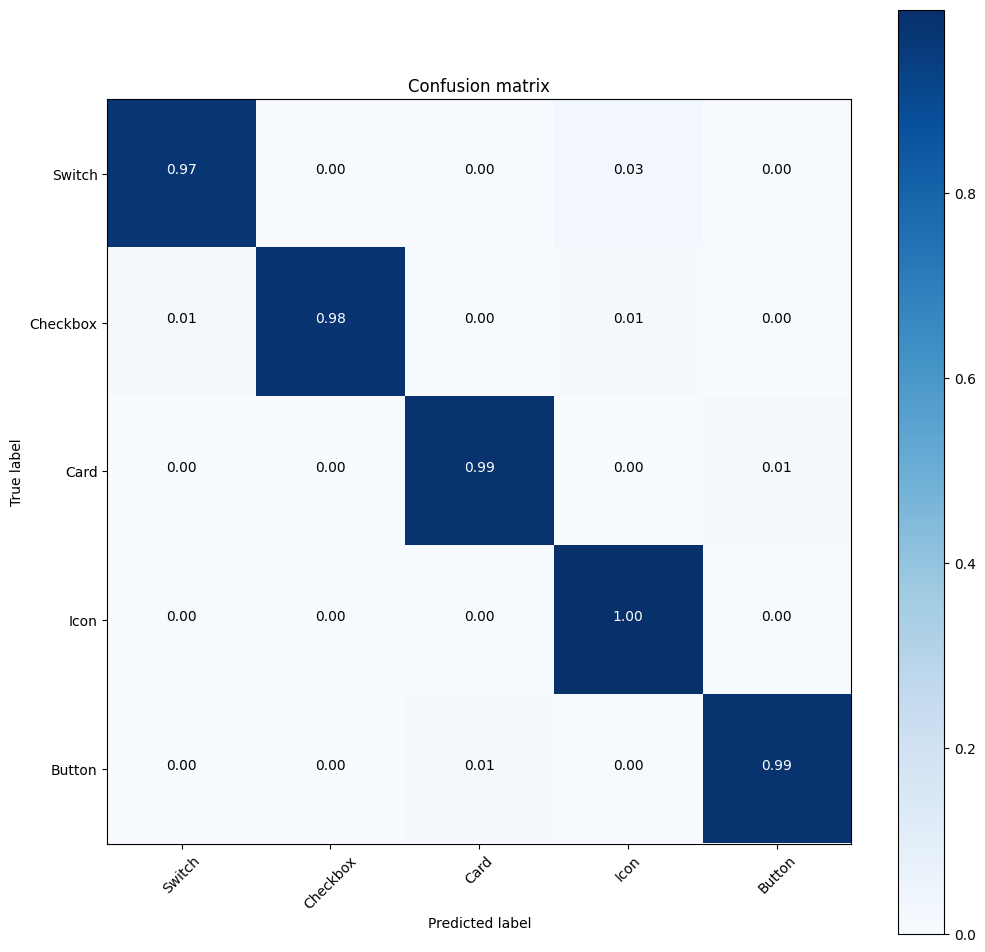

In [41]:

# test_generator.reset()
y_pred_softmax = model.predict(test_dataset_tf, steps=len(test_file_name)/w_config.batch_size)
y_pred = y_pred_softmax.argmax(axis=1)
y_test = np.argmax(test_label,axis=1)
matrix = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(matrix, classes_test , title = "Confusion matrix",
                      normalize=True, save_name=os.path.join(save_folder, 'conf_mat_test.png'))


clf_report = metrics.classification_report(y_test, y_pred , target_names=classes_test)
print(clf_report)
clf_report = metrics.classification_report(y_test, y_pred , target_names=classes_test, output_dict=True)


df = pd.DataFrame(clf_report).transpose()
df.to_csv(os.path.join(save_folder, 'classification_report_test.csv'), sep='\t')


d = {'y_pred': y_pred_softmax,
    'y_pred_argmax': y_pred,
    'y_true': y_test,
    'cmat': matrix,
    'cls_lbl_map': classes_test,
    'file_names': test_file_name}
with open(os.path.join(save_folder, "test_pred.pk"), "wb") as output_file:
    pkl.dump(d, output_file)
    
    

w_config.test_accuracy = clf_report['accuracy']


In [42]:
%%javascript
$("#save-notbook button").trigger('click');

<IPython.core.display.Javascript object>

Reinitializing Datagenerators for train and validation datasets by keeping augmentation and shuffle flag as False

In [43]:

train_data_gen, train_dataset_tf = give_generator_v2(file_names=train_file_name, labels=train_label, shuffle=False, 
                                   batch_size=w_config.batch_size, repeat=False, buffer_size=512, prefetch=True)

val_data_gen, val_dataset_tf = give_generator_v2(file_names=val_file_name, labels=val_label, shuffle=False, 
                                 batch_size=w_config.batch_size, repeat=False, buffer_size=512, prefetch=True)


2023-04-02 01:25:42.087747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [8838,5]
	 [[{{node Placeholder/_1}}]]
2023-04-02 01:25:42.088296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype bool and shape [8838]
	 [[{{node Placeholder/_2}}]]
2023-04-02 01:25:42.625007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype bool and shape [2209]
	

Objective: For <b>inferencing</b> <br>
Confusion matrix and Classification report on Train dataset



69/69 [==============================] - 13s 190ms/step
Normalized confusion matrix
              precision    recall  f1-score   support

      Switch       0.97      0.98      0.97       257
    Checkbox       1.00      0.99      1.00      1016
        Card       1.00      1.00      1.00      1741
        Icon       1.00      1.00      1.00      3707
      Button       1.00      1.00      1.00      2117

    accuracy                           1.00      8838
   macro avg       0.99      0.99      0.99      8838
weighted avg       1.00      1.00      1.00      8838



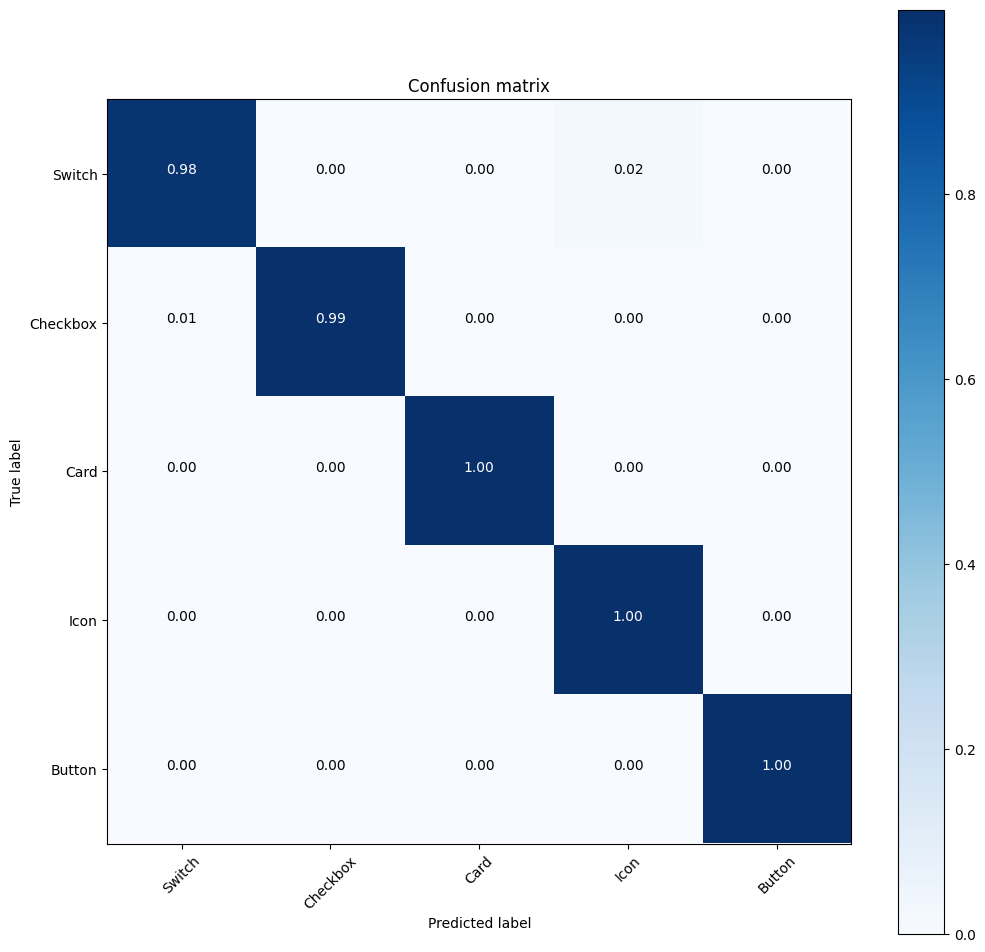

In [44]:

y_pred_softmax = model.predict(train_dataset_tf, steps=len(train_file_name)/w_config.batch_size)
y_pred = y_pred_softmax.argmax(axis=1)
y_test = np.argmax(train_label,axis=1)
matrix = confusion_matrix(y_test, y_pred)


plot_confusion_matrix(matrix, classes_test , title = "Confusion matrix",
                      normalize=True, save_name=os.path.join(save_folder, 'conf_mat_train.png'))


clf_report = metrics.classification_report(y_test, y_pred , target_names=classes_train)
print(clf_report)
clf_report = metrics.classification_report(y_test, y_pred , target_names=classes_train, output_dict=True)


df = pd.DataFrame(clf_report).transpose()
df.to_csv(os.path.join(save_folder, 'classification_report_train.csv'), sep='\t')


d = {'y_pred': y_pred_softmax,
    'y_pred_argmax': y_pred,
    'y_true': y_test,
    'cmat': matrix,
    'cls_lbl_map': classes_train,
    'file_names': train_file_name}
with open(os.path.join(save_folder, "train_pred.pk"), "wb") as output_file:
    pkl.dump(d, output_file)
    
w_config.train_accuracy = clf_report['accuracy']

Objective: For <b>inferencing</b> <br>

Confusion matrix and Classification report Validation dataset


17/17 [==============================] - 5s 274ms/step
Normalized confusion matrix
              precision    recall  f1-score   support

      Switch       0.99      0.97      0.98        70
    Checkbox       0.99      0.99      0.99       258
        Card       0.99      1.00      0.99       428
        Icon       0.99      1.00      1.00       918
      Button       0.99      0.99      0.99       535

    accuracy                           0.99      2209
   macro avg       0.99      0.99      0.99      2209
weighted avg       0.99      0.99      0.99      2209



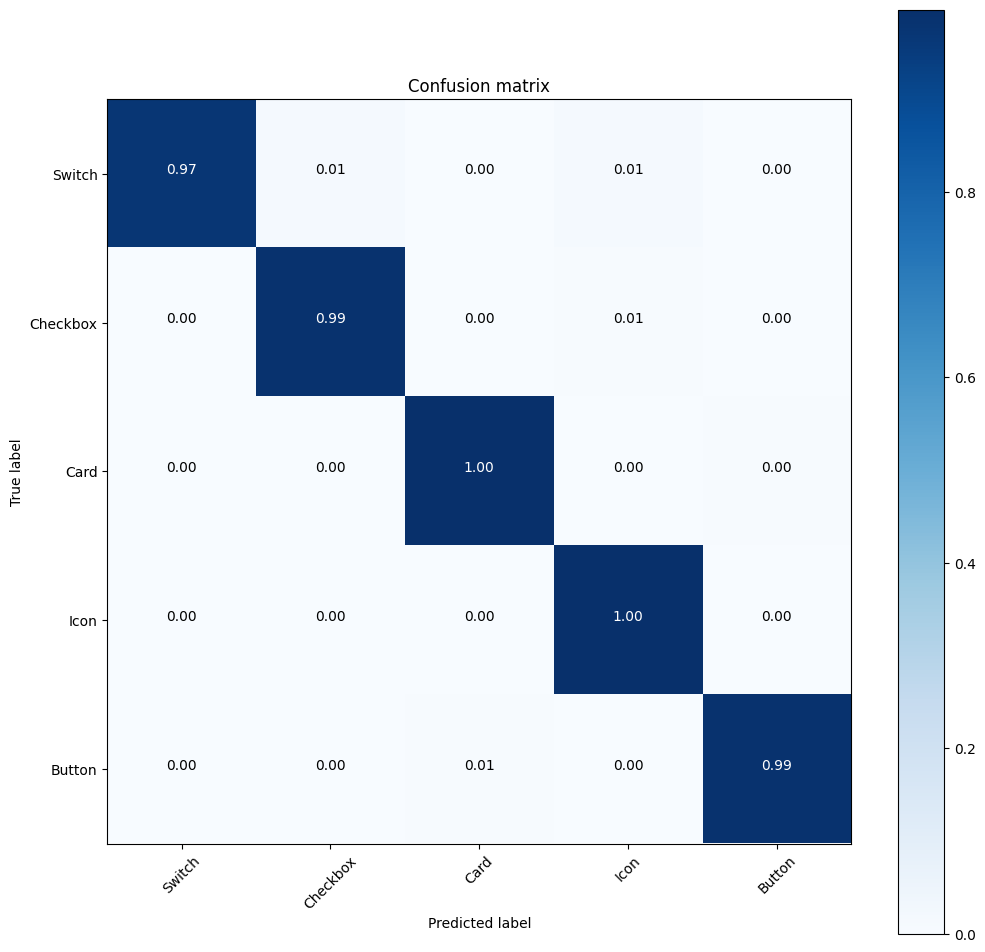

In [45]:

y_pred_softmax = model.predict(val_dataset_tf, steps=len(val_file_name)/w_config.batch_size)
y_pred = y_pred_softmax.argmax(axis=1)
y_test = np.argmax(val_label,axis=1)
matrix = confusion_matrix(y_test, y_pred)


plot_confusion_matrix(matrix, classes_test , title = "Confusion matrix",
                      normalize=True, save_name=os.path.join(save_folder, 'conf_mat_val.png'))


clf_report = metrics.classification_report(y_test, y_pred , target_names=classes_train)
print(clf_report)
clf_report = metrics.classification_report(y_test, y_pred , target_names=classes_train, output_dict=True)


df = pd.DataFrame(clf_report).transpose()
df.to_csv(os.path.join(save_folder, 'classification_report_val.csv'), sep='\t')


d = {'y_pred': y_pred_softmax,
    'y_pred_argmax': y_pred,
    'y_true': y_test,
    'cmat': matrix,
    'cls_lbl_map': classes_train,
    'file_names': val_file_name}
with open(os.path.join(save_folder, "val_pred.pk"), "wb") as output_file:
    pkl.dump(d, output_file)
    
w_config.val_accuracy = clf_report['accuracy']

In [ ]:
%%javascript
$("#save-notbook button").trigger('click');

In [ ]:
!cp {notebook_name} {save_folder}